In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sem import SEM, LinearDynamicSystem

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


Now, we define some toy problem

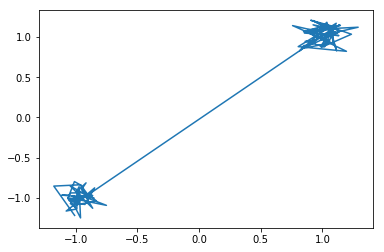

In [2]:
# first demo -- gaussian mixture defined by the CRP
np.random.seed(12313123)

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_static_dataset(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [3]:
K = 20  # maximum number of event types
lmda = 10.  # stickyness parameter
alfa = 1.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)

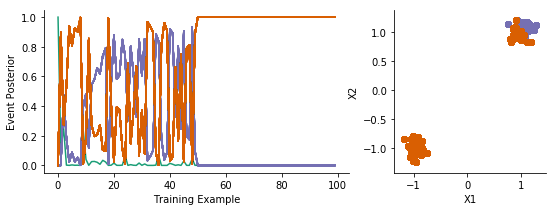

In [4]:
def plot_segmentation(post):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios':[2, 1]})
    cluster_id = np.argmax(post, axis=1)
    import seaborn as sns
    cc = sns.color_palette('Dark2', post.shape[1])
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])
    axes[1].set_xlabel('X1')
    axes[1].set_ylabel('X2')

    for clt in cluster_id:
        axes[0].plot(post[:, clt], color=cc[clt])
        
    axes[0].set_xlabel('Training Example')
    axes[0].set_ylabel('Event Posterior')
    
    sns.despine()
    
plot_segmentation(post)

In [5]:
# np.max(post, axis=1)
post.shape

(100, 20)

In [6]:
#show the envent number that was chosen
np.argmax(post, axis=1)

array([0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Now, alternative between two events


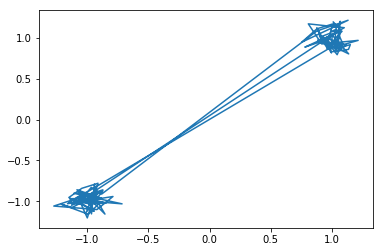

In [7]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [8]:
post = sem.run(x_train, K=K)

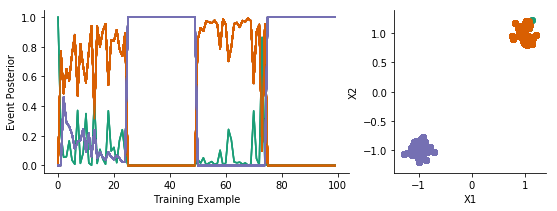

In [9]:
plot_segmentation(post)

In [10]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

Below an example of two events where the events correspond to movement in vector space

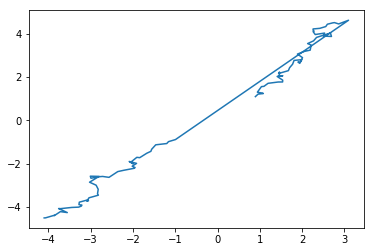

In [11]:

def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [12]:
post = sem.run(x_train, K=K)

sem.py:243: RuntimeWarning: divide by zero encountered in log
  return np.log(multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma))


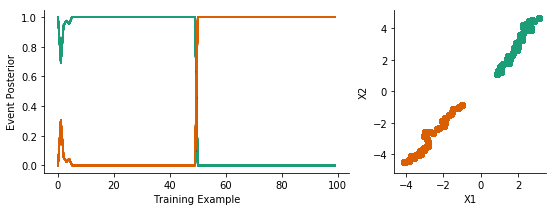

In [13]:
plot_segmentation(post)

In [14]:
np.argmax(post, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

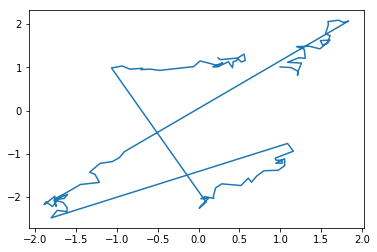

In [15]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [16]:
post = sem.run(x_train, K=K)

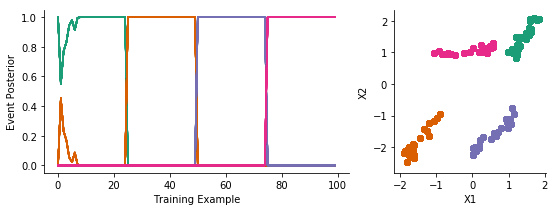

In [17]:
plot_segmentation(post)

In [18]:
np.argmax(post, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

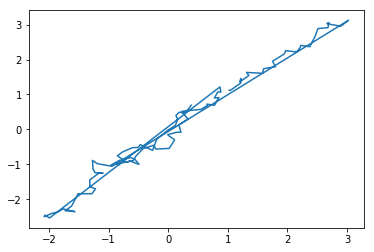

In [19]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

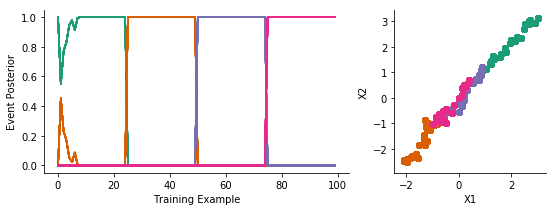

In [20]:
plot_segmentation(post)

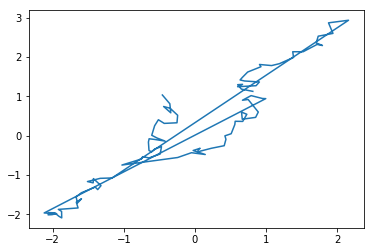

In [21]:

def build_rotation(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    
    
    bs = [0, 0]  # starting point!

    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])